In [21]:
import json

# Charger les données des fichiers JSON
with open('données_normales.json', 'r') as f:
    donnees_normales = json.load(f)

with open('données_malveillantes.json', 'r') as f:
    donnees_malveillantes = json.load(f)

# Ajouter la colonne is_attack
for donnee in donnees_normales:
    donnee['is_attack'] = 0

for donnee in donnees_malveillantes:
    donnee['is_attack'] = 1

# Fusionner les deux listes de données
donnees_fusionnees = donnees_normales + donnees_malveillantes

# Afficher un exemple de données fusionnées
print(donnees_fusionnees[:2])

[{'method': 'GET', 'url': '/htmli_get.php', 'query_parameters': {'firstname': '<h1>Alice</h1>', 'lastname': '<div>Dupont</div>', 'address': "<script>alert('XSS')</script>", 'email': '<img src="x" onerror="alert(\'XSS\')">', 'form': 'submit'}, 'headers': {'Host': '127.0.0.1:8000', 'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8', 'Accept-Language': 'en-US,en;q=0.5', 'Accept-Encoding': 'gzip, deflate, br', 'Connection': 'keep-alive', 'Referer': "http://127.0.0.1:8000/htmli_get.php?firstname=%3Ch1%3EAlice%3C%2Fh1%3E&lastname=%3Cdiv%3EDupont%3C%2Fdiv%3E&address=%3Cscript%3Ealert('XSS')%3C%2Fscript%3E&email=%3Cimg%20src%3D%22x%22%20onerror%3D%22alert('XSS')%22%3E&form=submit", 'Cookie': 'security_level=0; PHPSESSID=5oat10nbn3rene9rfj94lc52i7', 'Upgrade-Insecure-Requests': '1', 'Sec-Fetch-Dest': 'document', 'Sec-Fetch-Mode': 'navigate', 'Sec-Fetch-Site': 's

In [3]:
# Sauvegarder les données fusionnées dans un fichier JSON
with open('donnees_fusionnees.json', 'w') as f:
    json.dump(donnees_fusionnees, f)

In [22]:
import json
import csv

# Charger le fichier JSON
with open('donnees_fusionnees.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Ouvrir un fichier CSV en mode écriture
with open('donnees_fusionnees.csv', 'w', encoding='utf-8', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Si le JSON est une liste d'objets
    if isinstance(data, list):
        # Convertir les dictionnaires dans query_parameters et headers en chaînes JSON
        for item in data:
            if isinstance(item.get('query_parameters'), dict):
                item['query_parameters'] = json.dumps(item['query_parameters'])
            if isinstance(item.get('headers'), dict):
                item['headers'] = json.dumps(item['headers'])
        
        # Écrire les en-têtes (clés du premier élément)
        writer.writerow(data[0].keys())
        
        # Écrire les valeurs de chaque objet JSON
        for item in data:
            writer.writerow(item.values())
    else:
        print("Le fichier JSON n'est pas dans le bon format pour une conversion en CSV.")


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import json

# Charger les données depuis un fichier CSV
df = pd.read_csv('donnees_fusionnees.csv')

# Fonction pour détecter les mots-clés SQL
def detect_sql_keywords(query):
    sql_keywords = ["SELECT", "INSERT", "UPDATE", "DELETE", "DROP", "UNION", "ALTER", "CREATE", "EXEC", "XP_"]
    return any(keyword in query.upper() for keyword in sql_keywords)

# Ajouter une colonne pour détecter les mots-clés SQL
if 'query_parameters' in df.columns:
    df['sql_keywords_detected'] = df['query_parameters'].apply(
        lambda x: detect_sql_keywords(x) if isinstance(x, str) else False
    )

# Supprimer les colonnes inutiles et encoder les variables catégoriques
X = df[['method', 'url', 'query_parameters', 'headers']]  # Modifier en fonction des colonnes pertinentes du CSV
X = pd.get_dummies(X, columns=['method', 'url', 'query_parameters', 'headers'], dummy_na=True)

# Sauvegarder les colonnes utilisées dans un fichier JSON
with open('columns.json', 'w') as f:
    json.dump(list(X.columns), f)

# Variable cible (modifier 'is_attack' si le nom de la colonne est différent dans le CSV)
y = df['is_attack']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Sauvegarder le modèle
dump(model, 'forensic.pkl')

# Évaluer le modèle
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6666666666666666


In [33]:
print(df.columns)


Index(['method', 'url', 'query_parameters', 'headers', 'is_attack'], dtype='object')


In [38]:
print(df['is_attack'].value_counts())


is_attack
0    19
1    11
Name: count, dtype: int64


In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Validation croisée - Accuracy :", scores.mean())


Validation croisée - Accuracy : 0.6333333333333333


In [36]:
feature_importances = model.feature_importances_
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance}")


method_GET: 0.016775334143057135
method_POST: 0.024909026348495886
method_nan: 0.0
url_/htmli_get.php: 0.021170251752839278
url_/htmli_post.php: 0.014074431085429641
url_/htmli_stored.php: 0.01309072631682522
url_nan: 0.0
query_parameters_{"Host": "127.0.0.1:8000", "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.5", "Accept-Encoding": "gzip, deflate, br", "Content-Type": "application/x-www-form-urlencoded", "Content-Length": "217", "Origin": "http://127.0.0.1:8000", "Connection": "keep-alive", "Referer": "http://127.0.0.1:8000/htmli_post.php", "Cookie": "security_level=0; PHPSESSID=5678abcd9101mnop3456qrstu", "Upgrade-Insecure-Requests": "1", "Sec-Fetch-Dest": "document", "Sec-Fetch-Mode": "navigate", "Sec-Fetch-Site": "same-origin", "Sec-Fetch-User": "?1"}: 0.0
query_parameters_{"Host": "127.0.0.1:8000", "User-Agent

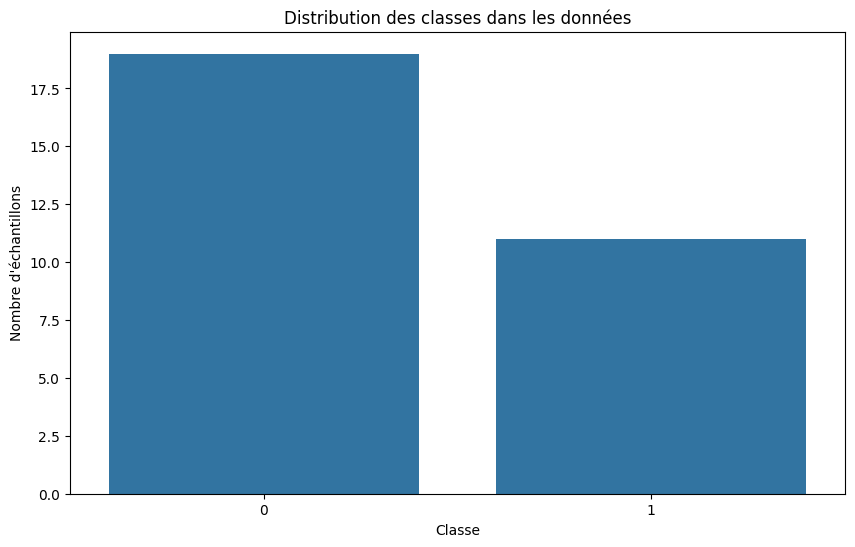

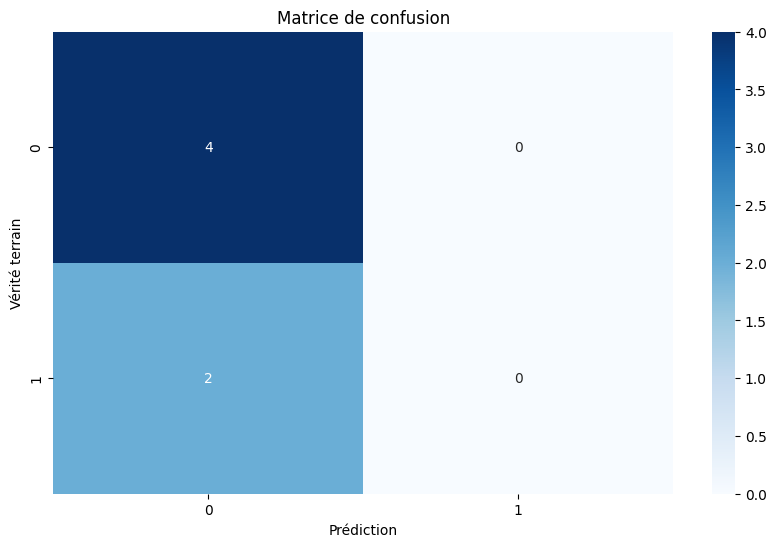

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Distribution des classes dans les données
plt.figure(figsize=(10, 6))
sns.countplot(x='is_attack', data=df)
plt.title('Distribution des classes dans les données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# Importance des caractéristiques
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

In [43]:
import pandas as pd

# Supposons que 'model' soit votre modèle entraîné et 'X_train' soit votre ensemble de données d'entraînement
feature_importances = model.feature_importances_
features = X_train.columns

# Créer un DataFrame pour les importances des caractéristiques
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher le tableau d'importance des caractéristiques
importance_df

,Feature,Importance
24,"query_parameters_{""firstname"": ""<h1>t</h1>"", ""...",0.085064
51,"headers_{""Host"": ""127.0.0.1:8000"", ""User-Agent...",0.056039
26,"query_parameters_{""firstname"": ""<i>InjectedIta...",0.049205
54,headers_{'firstname': '%3Ch1%3E%3Ca+href%3D%22...,0.045818
25,"query_parameters_{""firstname"": ""<h1>t</h1>"", ""...",0.044146
49,"headers_{""Host"": ""127.0.0.1:8000"", ""User-Agent...",0.042201
38,"headers_{""Host"": ""127.0.0.1:8000"", ""User-Agent...",0.042054
53,headers_{'firstname': '%3Ch1%3E%3Ca+href%3D%22...,0.041757
36,"headers_{""Host"": ""127.0.0.1:8000"", ""User-Agent...",0.037201
46,"headers_{""Host"": ""127.0.0.1:8000"", ""User-Agent...",0.036506


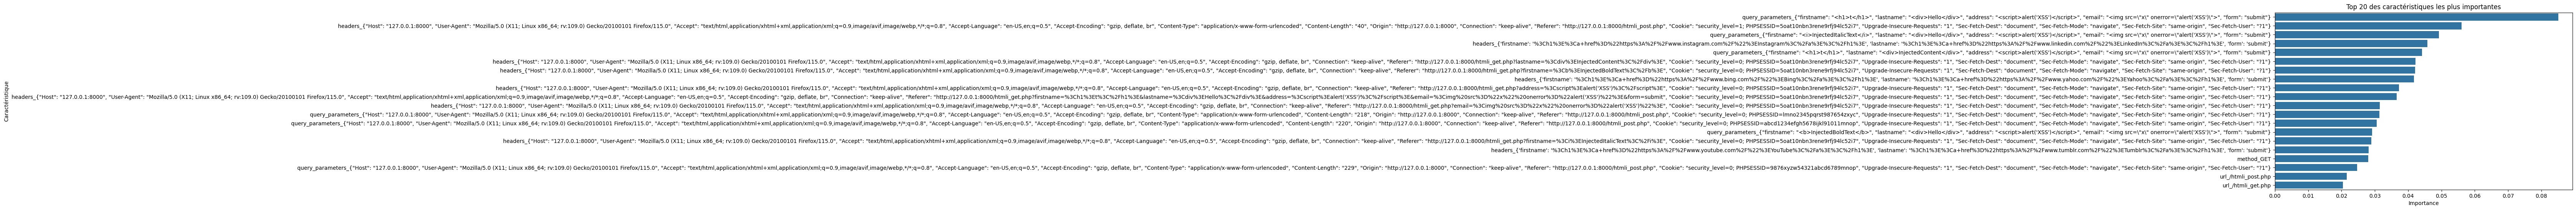

In [44]:
# Sélectionner les 20 caractéristiques les plus importantes
top_20_importance_df = importance_df.head(20)

# Afficher le tableau d'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df)
plt.title('Top 20 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()

In [45]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(model, 'forensic.pkl')

['forensic.pkl']